In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
from comet_ml import Experiment
from comet_ml.integration.sklearn import log_model

from dotenv import load_dotenv, find_dotenv
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.metrics import roc_curve, auc

import pickle
load_dotenv(find_dotenv())

COMET_API_KEY = os.environ.get("COMET_API_KEY")

In [2]:
ls

__init__.py                 baseline_experiments.ipynb


In [3]:
df = pd.read_csv("./../../data/FE1/20162019_clean 4.csv")
df.head(2)

,gamePk,season,gameType,home,away,eventTypeId,shotType,shooter,shooterTeam,distance,angle,goalie,eventPeriod,eventPeriodType,x,y,emptyNet,isGoal
0,2016020001,20162017,R,Ottawa Senators,Toronto Maple Leafs,HIT,NaN,NaN,NaN,NaN,NaN,NaN,3,REGULAR,-51.0,35.0,0,0
1,2016020001,20162017,R,Ottawa Senators,Toronto Maple Leafs,FACEOFF,NaN,NaN,NaN,NaN,NaN,NaN,2,REGULAR,69.0,22.0,0,0


In [4]:
df.shotType.unique()

array([nan, 'Wrist Shot', 'Snap Shot', 'Slap Shot', 'Tip-In', 'Backhand',
       'Deflected', 'Wrap-around'], dtype=object)

In [5]:
df.shotType.isna().sum()

1361282

In [6]:
cleaned_df = df[(~df.distance.isna())]
cleaned_df =  cleaned_df[cleaned_df['distance']!='shoot out']

In [7]:
cleaned_df.season.unique()

array([20162017, 20172018, 20182019, 20192020])

## Train and Validation split

- Here, we will use season `{20162017, 20172018, 20182019}` in training and `{20192020}` for validation.

In [8]:
train_seasons = [20162017, 20172018, 20182019]
train_df = cleaned_df[cleaned_df.season.isin(train_seasons)]
test_df = cleaned_df[~cleaned_df.season.isin(train_seasons)]
print(cleaned_df.shape, train_df.shape, test_df.shape)

(315818, 18) (245555, 18) (70263, 18)


In [9]:
def plot_roc_curve(model, X_val, y_val,title, experiment=None):
    
    fpr, tpr, thresholds = roc_curve( y_val, model.predict_proba(X_val)[:,1] )
    
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2,label='random baseline', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    if experiment:
        experiment.log_figure(figure_name=title, step=None)
    plt.show()

In [10]:
def run_experiment(name, model, X_train, y_train, X_test, y_test, ckpt_path="./../../models/"):
    experiment = Experiment(
      api_key=COMET_API_KEY,
      project_name="baselines",
      workspace="ift6758-milestone2-udem"
    )
    
    model.fit(X_train,y_train)
    file_name = name + '.pkl'
    with open(os.path.join(ckpt_path, file_name), 'wb') as file:  
        pickle.dump(model, file)    
    y_pred = model.predict(X_test)
    
    test_acc = metrics.accuracy_score(y_test, y_pred)
    print(f"Test accuracy :{test_acc}")
    plot_roc_curve(model, X_val, y_val,title="Baseline model AUROC", experiment=experiment)
    
    
    experiment.log_metric("Test accuracy", test_acc)
    experiment.log_model(name, os.path.join(ckpt_path, file_name))
    experiment.end()

In [11]:
model = LogisticRegression()

In [12]:
X_train = train_df[['distance']]
y_train = train_df[['isGoal']]

X_val = test_df[['distance']]
y_val = test_df[['isGoal']]

In [13]:
X_train.values.shape

(245555, 1)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-milestone2-udem/baselines/e1d7879aa4894430b3bc04c41e4d279c

/Users/iamyash/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test accuracy :0.9055406117017492


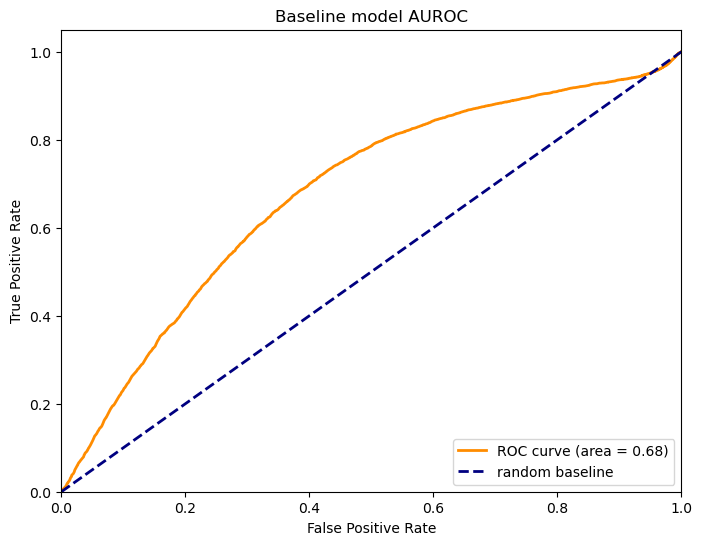

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-milestone2-udem/baselines/e1d7879aa4894430b3bc04c41e4d279c
COMET INFO:   Metrics:
COMET INFO:     Test accuracy : 0.9055406117017492
COMET INFO:   Parameters:
COMET INFO:     C                 : 1.0
COMET INFO:     class_weight      : None
COMET INFO:     dual              : False
COMET INFO:     fit_intercept     : True
COMET INFO:     intercept_scaling : 1
COMET INFO:     l1_ratio          : None
COMET INFO:     max_iter          : 100
COMET INFO:     multi_class       : auto
COMET INFO:     n_jobs            : None
COMET INFO:     penalty           : l2
COMET INFO:     random_state      : None
COMET INFO:     solver  

In [14]:
run_experiment("baseline_model", model, X_train, y_train, X_val, y_val, )

In [15]:
cleaned_df.isGoal.value_counts()

isGoal
0    286591
1     29227
Name: count, dtype: int64